In [1]:
!pip install timm
!pip install segmentation-models-pytorch timm
!pip install wandb

In [2]:
# =========================
# 0. 기본 설정 및 라이브러리 임포트
# =========================
# 1. Standard Library Imports
import random
import glob
import json
import os

# 2. Third-Party Imports (Data & Visualization)
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# 3. PyTorch Core Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

# 4. Deep Learning & Augmentation Libraries
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import timm

# 5. K-Fold 라이브러리
from sklearn.model_selection import GroupKFold

# 6. MLOps (WandB)
import wandb
os.environ["WANDB_API_KEY"] = "606f273cf9d1d864ce1e44e2ec1cbebef36d71c8"
wandb.login()

# 7. GPU & Seed 설정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 사용 중인 장치: {device}")
if torch.cuda.is_available():
    print(f"GPU 모델명: {torch.cuda.get_device_name(0)}")

# 8. 데이터 경로 설정
DATA_ROOT = '/data/ephemeral/home/data'
TRAIN_IMG_ROOT = os.path.join(DATA_ROOT, 'train/DCM')
TRAIN_LABEL_ROOT = os.path.join(DATA_ROOT, 'train/outputs_json')
SAVED_DIR = './saved_models'

if not os.path.exists(SAVED_DIR):
    os.makedirs(SAVED_DIR)

# 9. 클래스 정보
# 뼈 종류 (총 29개) - 순서가 바뀌면 안 됩니다.
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna'
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

# 10. 하이퍼파라미터
BATCH_SIZE = 4      # 안전한 배치 사이즈
IMAGE_SIZE = 512    # 메모리 효율을 위해 512 사용
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5      # Fold당 Epoch 수 (총 25 Epoch 수행됨)
NUM_FOLDS = 5       # 5-Fold

print("✅ 기본 설정 완료")



/data/ephemeral/home/py310/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
wandb: Currently logged in as: yujh5537 (cv_12) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


현재 사용 중인 장치: cuda
GPU 모델명: Tesla V100-SXM2-32GB
✅ 기본 설정 완료


In [3]:
# =========================
# 1. Dataset & DataLoader
# =========================
class XRayDataset(Dataset):
    def __init__(self, data_root, transforms=None):
        self.img_root = os.path.join(data_root, 'DCM')
        self.label_root = os.path.join(data_root, 'outputs_json')
        self.transforms = transforms
        
        self.fnames = sorted([
            f for f in os.listdir(self.img_root) 
            if os.path.isdir(os.path.join(self.img_root, f))
        ])
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, item):
        folder_id = self.fnames[item]
        img_folder = os.path.join(self.img_root, folder_id)
        img_path = glob.glob(os.path.join(img_folder, "*.png"))[0]
        
        label_folder = os.path.join(self.label_root, folder_id)
        json_path = glob.glob(os.path.join(label_folder, "*.json"))[0]
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        H, W, _ = image.shape
        
        label_mask = np.zeros((H, W, len(CLASSES)), dtype=np.uint8)
        with open(json_path, 'r') as f:
            annotations = json.load(f)
            
        for ann in annotations['annotations']:
            class_name = ann['label']
            class_ind = CLASS2IND[class_name]
            points = np.array(ann['points'])
            class_map = label_mask[:, :, class_ind].copy()
            cv2.fillPoly(class_map, [points], 1)
            label_mask[:, :, class_ind] = class_map

        if self.transforms:
            augmented = self.transforms(image=image, mask=label_mask)
            image = augmented['image']
            label_mask = augmented['mask']
            
        if not isinstance(image, torch.Tensor):
            image = image.transpose(2, 0, 1)
            label_mask = label_mask.transpose(2, 0, 1)
            image = torch.from_numpy(image).float() / 255.0
            label_mask = torch.from_numpy(label_mask).float()
            
        return image, label_mask

# Transform 설정
train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
])

# 전체 데이터셋 생성
full_dataset = XRayDataset(data_root='/data/ephemeral/home/data/train', transforms=train_transform)

print(f"✅ 데이터셋 설정 완료! (Size: {IMAGE_SIZE}x{IMAGE_SIZE}, Batch: {BATCH_SIZE})")

✅ 데이터셋 설정 완료! (Size: 512x512, Batch: 4)


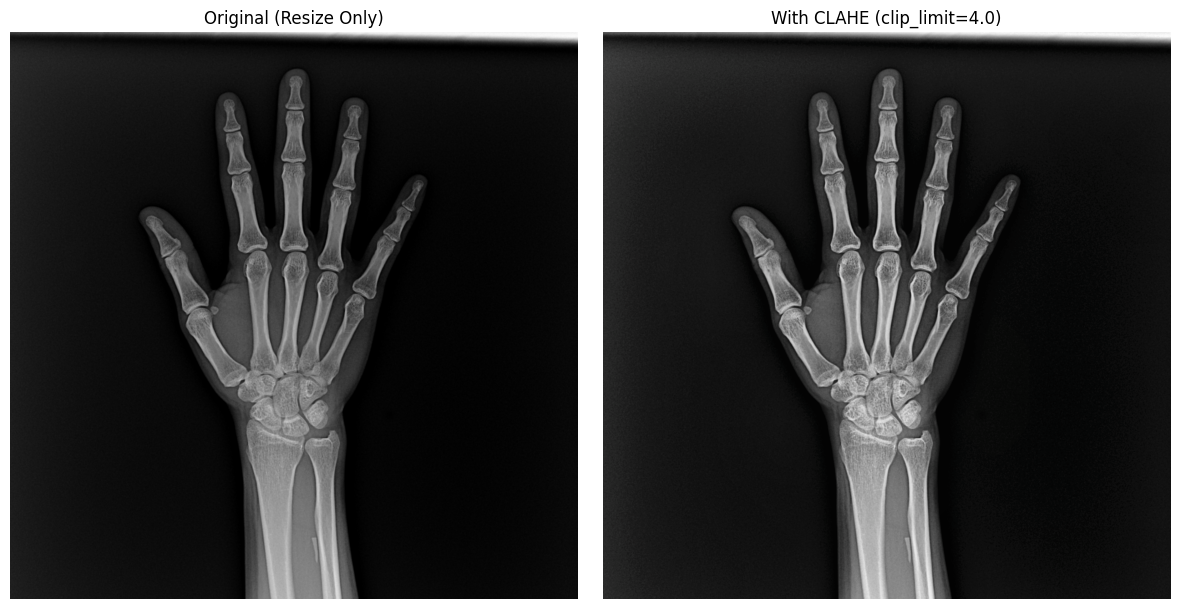

In [4]:
# =========================
# 1-1. 시각화용 샘플 가져오기
# =========================
def visualize_clahe_effect():
    # 1. 원본 이미지 하나 가져오기
    sample_img_path = glob.glob(os.path.join(TRAIN_IMG_ROOT, "*", "*.png"))[0]
    image = cv2.imread(sample_img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 2. CLAHE 적용 (확률 100%로 강제 적용)
    aug = A.Compose([
        A.Resize(1024, 1024),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0) 
    ])
    augmented = aug(image=image)['image']
    
    # 3. 비교 출력
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Original (Resize Only)")
    plt.imshow(cv2.resize(image, (1024, 1024)))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("With CLAHE (clip_limit=4.0)")
    plt.imshow(augmented)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_clahe_effect()

In [5]:
# =========================
# 2. Loss & Model Definition (HRNet-W32 + U-Net++)
# =========================
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class ComboLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(ComboLoss, self).__init__()
        self.weight = weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        bce = self.bce(inputs, targets)
        dice = self.dice(inputs, targets)
        return (self.weight * bce) + ((1 - self.weight) * dice)
    
# 모델 생성 함수 (Fold마다 새로 만들어야 함)
def get_model():
    model = smp.UnetPlusPlus(
        encoder_name="tu-hrnet_w48", 
        encoder_weights="imagenet",
        in_channels=3,
        classes=29
    )
    return model


print("✅ HRNet + U-Net++ 모델 로드 완료!")


✅ HRNet + U-Net++ 모델 로드 완료!


In [6]:
# =========================
# 3. 5-Fold Training Loop
# =========================
import torch.cuda.amp as amp 

# GroupKFold 설정
gkf = GroupKFold(n_splits=NUM_FOLDS)
groups = [x for x in full_dataset.fnames] # ID별로 그룹화

print(f"🚀 5-Fold Cross Validation 학습 시작! (총 {NUM_FOLDS} Folds)")
print("="*60)

for fold, (train_idx, val_idx) in enumerate(gkf.split(full_dataset, groups=groups)):
    print(f"\n# {'='*10} Fold {fold+1} / {NUM_FOLDS} {'='*10}")
    
    # 1. WandB 초기화 (Fold별 기록)
    try: wandb.finish()
    except: pass
    
    config = {
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "fold": fold + 1
    }
    wandb.init(project="U-Net++_HRNet", config=config, name=f"U-Net++_HRNet_KFold")

    # 2. 데이터셋 분할 (Subset 활용)
    # 주의: 검증셋에는 Augmentation(CLAHE, Flip 등)을 끄는 것이 정석이므로 transform을 교체합니다.
    train_ds = Subset(full_dataset, train_idx)
    val_ds = XRayDataset(data_root='/data/ephemeral/home/data/train', transforms=val_transform)
    val_ds = Subset(val_ds, val_idx) # 검증용 transform이 적용된 데이터셋에서 인덱스 추출

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    # 3. 모델 & Optimizer 초기화
    model = get_model().to(device)
    criterion = ComboLoss(weight=0.5)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = amp.GradScaler()
    
    # Best Model 저장을 위한 변수
    best_dice = 0.0
    
    for epoch in range(NUM_EPOCHS):
        # [Training Phase]
        model.train()
        train_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Fold {fold+1} Epoch [{epoch+1}/{NUM_EPOCHS}] Train")
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            
            with amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            pbar.set_postfix({'Loss': round(loss.item(), 4)})
            
        avg_train_loss = train_loss / len(train_loader)
        
        # [Validation Phase]
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Fold {fold+1} Epoch [{epoch+1}/{NUM_EPOCHS}] Valid"):
                images, masks = images.to(device), masks.to(device)
                
                with amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                
                # Dice Score 계산 (Threshold 0.5)
                pred_mask = (torch.sigmoid(outputs) > 0.5).float()
                intersection = (pred_mask * masks).sum()
                dice = (2. * intersection) / (pred_mask.sum() + masks.sum() + 1e-7)
                val_dice += dice.item()
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        
        print(f"📈 [Fold {fold+1}] Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")
        
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_dice": avg_val_dice,
            "epoch": epoch + 1
        })
        
        # Best Model 저장
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            save_path = os.path.join(SAVED_DIR, f'best_model_fold_{fold+1}.pt')
            torch.save(model.state_dict(), save_path)
            print(f"🎉 Best Model Saved! (Dice: {best_dice:.4f}) -> {save_path}")

print("\n✅ 모든 Fold 학습 완료!")

🚀 5-Fold Cross Validation 학습 시작! (총 5 Folds)

# ========== Fold 1 / 5 ==========


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Fold 1 Epoch [1/

📈 [Fold 1] Epoch 1 | Train Loss: 0.8011 | Val Loss: 0.7488 | Val Dice: 0.0150
🎉 Best Model Saved! (Dice: 0.0150) -> ./saved_models/best_model_fold_1.pt


Fold 1 Epoch [2/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


📈 [Fold 1] Epoch 2 | Train Loss: 0.6890 | Val Loss: 0.6425 | Val Dice: 0.0426
🎉 Best Model Saved! (Dice: 0.0426) -> ./saved_models/best_model_fold_1.pt


Fold 1 Epoch [3/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


📈 [Fold 1] Epoch 3 | Train Loss: 0.6130 | Val Loss: 0.5887 | Val Dice: 0.1306
🎉 Best Model Saved! (Dice: 0.1306) -> ./saved_models/best_model_fold_1.pt


Fold 1 Epoch [4/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


📈 [Fold 1] Epoch 4 | Train Loss: 0.5730 | Val Loss: 0.5582 | Val Dice: 0.1412
🎉 Best Model Saved! (Dice: 0.1412) -> ./saved_models/best_model_fold_1.pt


Fold 1 Epoch [5/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


📈 [Fold 1] Epoch 5 | Train Loss: 0.5481 | Val Loss: 0.5379 | Val Dice: 0.2629
🎉 Best Model Saved! (Dice: 0.2629) -> ./saved_models/best_model_fold_1.pt

# ========== Fold 2 / 5 ==========


epoch,▁▃▅▆█
train_loss,█▅▃▂▁
val_dice,▁▂▄▅█
val_loss,█▄▃▂▁
epoch,5
train_loss,0.54806
val_dice,0.26291
val_loss,0.53786


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Fold 2 Epoch [1/

📈 [Fold 2] Epoch 1 | Train Loss: 0.8028 | Val Loss: 0.7537 | Val Dice: 0.0220
🎉 Best Model Saved! (Dice: 0.0220) -> ./saved_models/best_model_fold_2.pt


Fold 2 Epoch [2/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


📈 [Fold 2] Epoch 2 | Train Loss: 0.6969 | Val Loss: 0.6499 | Val Dice: 0.0759
🎉 Best Model Saved! (Dice: 0.0759) -> ./saved_models/best_model_fold_2.pt


Fold 2 Epoch [3/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


📈 [Fold 2] Epoch 3 | Train Loss: 0.6173 | Val Loss: 0.5924 | Val Dice: 0.0463


Fold 2 Epoch [4/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


📈 [Fold 2] Epoch 4 | Train Loss: 0.5742 | Val Loss: 0.5602 | Val Dice: 0.1368
🎉 Best Model Saved! (Dice: 0.1368) -> ./saved_models/best_model_fold_2.pt


Fold 2 Epoch [5/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


📈 [Fold 2] Epoch 5 | Train Loss: 0.5475 | Val Loss: 0.5382 | Val Dice: 0.2688
🎉 Best Model Saved! (Dice: 0.2688) -> ./saved_models/best_model_fold_2.pt

# ========== Fold 3 / 5 ==========


epoch,▁▃▅▆█
train_loss,█▅▃▂▁
val_dice,▁▃▂▄█
val_loss,█▅▃▂▁
epoch,5
train_loss,0.5475
val_dice,0.2688
val_loss,0.53823


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Fold 3 Epoch [1/

📈 [Fold 3] Epoch 1 | Train Loss: 0.8181 | Val Loss: 0.7593 | Val Dice: 0.0247
🎉 Best Model Saved! (Dice: 0.0247) -> ./saved_models/best_model_fold_3.pt


Fold 3 Epoch [2/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


📈 [Fold 3] Epoch 2 | Train Loss: 0.6936 | Val Loss: 0.6465 | Val Dice: 0.1905
🎉 Best Model Saved! (Dice: 0.1905) -> ./saved_models/best_model_fold_3.pt


Fold 3 Epoch [3/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


📈 [Fold 3] Epoch 3 | Train Loss: 0.6156 | Val Loss: 0.5937 | Val Dice: 0.2384
🎉 Best Model Saved! (Dice: 0.2384) -> ./saved_models/best_model_fold_3.pt


Fold 3 Epoch [4/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


📈 [Fold 3] Epoch 4 | Train Loss: 0.5730 | Val Loss: 0.5574 | Val Dice: 0.2440
🎉 Best Model Saved! (Dice: 0.2440) -> ./saved_models/best_model_fold_3.pt


Fold 3 Epoch [5/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


📈 [Fold 3] Epoch 5 | Train Loss: 0.5471 | Val Loss: 0.5371 | Val Dice: 0.2486
🎉 Best Model Saved! (Dice: 0.2486) -> ./saved_models/best_model_fold_3.pt

# ========== Fold 4 / 5 ==========


epoch,▁▃▅▆█
train_loss,█▅▃▂▁
val_dice,▁▆███
val_loss,█▄▃▂▁
epoch,5
train_loss,0.54707
val_dice,0.24861
val_loss,0.53707


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Fold 4 Epoch [1/

📈 [Fold 4] Epoch 1 | Train Loss: 0.7929 | Val Loss: 0.7291 | Val Dice: 0.0388
🎉 Best Model Saved! (Dice: 0.0388) -> ./saved_models/best_model_fold_4.pt


Fold 4 Epoch [2/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


📈 [Fold 4] Epoch 2 | Train Loss: 0.6802 | Val Loss: 0.6423 | Val Dice: 0.0962
🎉 Best Model Saved! (Dice: 0.0962) -> ./saved_models/best_model_fold_4.pt


Fold 4 Epoch [3/5] Valid: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


📈 [Fold 4] Epoch 3 | Train Loss: 0.6135 | Val Loss: 0.5928 | Val Dice: 0.0655


Fold 4 Epoch [4/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


📈 [Fold 4] Epoch 4 | Train Loss: 0.5755 | Val Loss: 0.5625 | Val Dice: 0.0653


Fold 4 Epoch [5/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


📈 [Fold 4] Epoch 5 | Train Loss: 0.5512 | Val Loss: 0.5415 | Val Dice: 0.1177
🎉 Best Model Saved! (Dice: 0.1177) -> ./saved_models/best_model_fold_4.pt

# ========== Fold 5 / 5 ==========


epoch,▁▃▅▆█
train_loss,█▅▃▂▁
val_dice,▁▆▃▃█
val_loss,█▅▃▂▁
epoch,5
train_loss,0.55118
val_dice,0.11766
val_loss,0.54152


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Fold 5 Epoch [1/

📈 [Fold 5] Epoch 1 | Train Loss: 0.7933 | Val Loss: 0.7372 | Val Dice: 0.0184
🎉 Best Model Saved! (Dice: 0.0184) -> ./saved_models/best_model_fold_5.pt


Fold 5 Epoch [2/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


📈 [Fold 5] Epoch 2 | Train Loss: 0.6991 | Val Loss: 0.6590 | Val Dice: 0.0417
🎉 Best Model Saved! (Dice: 0.0417) -> ./saved_models/best_model_fold_5.pt


Fold 5 Epoch [3/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


📈 [Fold 5] Epoch 3 | Train Loss: 0.6243 | Val Loss: 0.5960 | Val Dice: 0.1480
🎉 Best Model Saved! (Dice: 0.1480) -> ./saved_models/best_model_fold_5.pt


Fold 5 Epoch [4/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


📈 [Fold 5] Epoch 4 | Train Loss: 0.5751 | Val Loss: 0.5589 | Val Dice: 0.2091
🎉 Best Model Saved! (Dice: 0.2091) -> ./saved_models/best_model_fold_5.pt


Fold 5 Epoch [5/5] Valid: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


📈 [Fold 5] Epoch 5 | Train Loss: 0.5480 | Val Loss: 0.5391 | Val Dice: 0.2114
🎉 Best Model Saved! (Dice: 0.2114) -> ./saved_models/best_model_fold_5.pt

✅ 모든 Fold 학습 완료!


In [7]:
# =========================
# 4. Ensemble Inference (5-Fold Soft Voting)
# =========================
# 1. RLE 인코딩 함수
def encode_mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 2. Test Dataset & Loader
class XRayInferenceDataset(Dataset):
    def __init__(self, data_root, transforms=None):
        self.img_root = os.path.join(data_root, 'test', 'DCM')
        self.transforms = transforms
        self.fnames = sorted([f for f in os.listdir(self.img_root) if os.path.isdir(os.path.join(self.img_root, f))])
        
    def __len__(self): return len(self.fnames)
    
    def __getitem__(self, item):
        folder_id = self.fnames[item]
        img_folder = os.path.join(self.img_root, folder_id)
        img_path = glob.glob(os.path.join(img_folder, "*.png"))[0]
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            image = self.transforms(image=image)['image']
            
        if not isinstance(image, torch.Tensor):
            image = image.transpose(2, 0, 1)
            image = torch.from_numpy(image).float() / 255.0
            
        return image, os.path.basename(img_path)

test_transform = A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE)])
test_dataset = XRayInferenceDataset(data_root='/data/ephemeral/home/data', transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# 3. 앙상블 추론 시작
print("\n🚀 5-Fold 앙상블 추론 시작...")

rles = []
filename_and_class = []

# 저장된 5개의 Best Model 경로
model_paths = [os.path.join(SAVED_DIR, f'best_model_fold_{i+1}.pt') for i in range(NUM_FOLDS)]

# (메모리 문제로 모델을 하나씩 로드해서 예측 결과를 누적하지 않고, 
#  배치 단위로 5개 모델을 순차적으로 돌려 결과를 합칩니다. 이 방식이 V100 메모리에 안전합니다.)
#  하지만 코드가 복잡해지므로, 여기서는 직관적으로 '모델 하나씩 로드 -> 전체 예측 -> 평균' 방식을 쓰되, 
#  메모리 관리를 위해 예측값을 저장하지 않고 바로 RLE로 변환하는 방식을 쓰려면 5개를 동시에 띄워야 합니다.
#  V100 32GB에서는 HRNet 5개를 동시에 띄우면 터질 수 있습니다.

# [전략] 배치를 하나 꺼내서 -> 모델 5개를 순차적으로 통과(Load/Unload는 느리니 제외) -> 확률 합산
# -> 모델 5개를 미리 리스트에 로드합니다. (V100 32GB라면 HRNet 5개 추론 모드(eval) 로드는 가능할 수 있음. 
# 만약 OOM 나면 '모델 1개로 전체 추론 후 저장 -> 다음 모델' 방식을 써야 함. 
# 여기서는 가장 안전한 '모델 1개씩 순차 적용' 방식을 구현합니다.)

# 결과를 담을 딕셔너리 (Key: ImageName, Value: Accumulated Probability)
# 주의: 전체 이미지를 메모리에 올리면 터집니다. 
# 따라서, 가장 현실적인 방법: "Test Loader 루프 안에서 5개 모델을 매번 적용" (속도 느림, 메모리 안전)
# 또는 "모델들을 미리 로드해두기". 512px 크기이므로 모델 5개 로드 시도해봅니다.

models = []
for p in model_paths:
    if os.path.exists(p):
        m = get_model()
        m.load_state_dict(torch.load(p))
        m.to(device)
        m.eval()
        models.append(m)
        print(f"Loaded: {p}")

if len(models) == 0:
    print("⚠️ 학습된 모델이 없습니다! Training Loop를 먼저 실행하세요.")
else:
    with torch.no_grad():
        for images, image_names in tqdm(test_loader, desc="Ensemble Inference"):
            images = images.to(device)
            
            # 5개 모델 예측 합산 (Soft Voting)
            ensemble_output = torch.zeros((images.size(0), 29, 2048, 2048), device=device)
            
            for model in models:
                # 1. 예측 (512px)
                output = model(images)
                # 2. 2048px 복원
                output = F.interpolate(output, size=(2048, 2048), mode="bilinear", align_corners=False)
                # 3. 확률 변환 (Sigmoid)
                output = torch.sigmoid(output)
                # 4. 합산
                ensemble_output += output
            
            # 평균 계산
            ensemble_output /= len(models)
            
            # Threshold 적용 및 RLE 인코딩
            ensemble_output = (ensemble_output > 0.5).detach().cpu().numpy()
            
            for output, image_name in zip(ensemble_output, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{CLASSES[c]}_{image_name}")

    # CSV 저장
    classes, filename = zip(*[x.split("_") for x in filename_and_class])
    image_name = [os.path.basename(f) for f in filename]
    
    df = pd.DataFrame({
        "image_name": image_name,
        "class": classes,
        "rle": rles,
    })
    
    save_path = "./HRNet_UNet++_K-Fold.csv"
    df.to_csv(save_path, index=False)
    print(f"🎉 앙상블 제출 파일 생성 완료! : {save_path}")


🚀 5-Fold 앙상블 추론 시작...


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Loaded: ./saved_models/best_model_fold_1.pt


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Loaded: ./saved_models/best_model_fold_2.pt


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Loaded: ./saved_models/best_model_fold_3.pt


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Loaded: ./saved_models/best_model_fold_4.pt


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Loaded: ./saved_models/best_model_fold_5.pt


Ensemble Inference: 100%|██████████| 36/36 [02:03<00:00,  3.42s/it]

🎉 앙상블 제출 파일 생성 완료! : ./HRNet_UNet++_K-Fold.csv


In [8]:
# =========================
#
# =========================
